In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             RocCurveDisplay)
import matplotlib.pyplot as plt

In [ ]:
# Reload and preprocess
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
df = df.drop('customerID', axis=1)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

X = df.drop('Churn', axis=1)
y = df['Churn']

num_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_columns = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_columns),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_columns)
], remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [3]:
print(f"Train: {X_train_processed.shape}, Test: {X_test_processed.shape}")

Train: (5625, 30), Test: (1407, 30)


In [ ]:
#Logistic Regression Baseline
# Train
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# Predict
lr_pred=lr_model.predict(X_test_processed)
lr_prob=lr_model.predict_proba(X_test_processed)[:,1]

In [ ]:
# Evaluate
print("=== Logistic Regression ===")
print(f"Accuracy:{accuracy_score(y_test,lr_pred):.4f}")
print(f"Precision: {precision_score(y_test, lr_pred):.4f}")
print(f"Recall:    {recall_score(y_test, lr_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, lr_pred):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test, lr_prob):.4f}")


=== Logistic Regression ===
Accuracy:0.8045
Precision: 0.6505
Recall:    0.5722
F1 Score:  0.6088
AUC-ROC:   0.8361


In [11]:
#Random Forest Baseline
#train
rf_model=RandomForestClassifier(n_estimators=100,random_state=42)
rf_model.fit(X_train_processed,y_train)

RandomForestClassifier(random_state=42)

In [12]:
#predict
rf_pred=rf_model.predict(X_test_processed)
rf_prob=rf_model.predict_proba(X_test_processed)[:,1]

In [13]:
#Evaluate
print("=== Random Forest ===")
print(f"Accuracy:  {accuracy_score(y_test, rf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_pred):.4f}")
print(f"Recall:    {recall_score(y_test, rf_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, rf_pred):.4f}")
print(f"AUC-ROC:   {roc_auc_score(y_test, rf_prob):.4f}")

=== Random Forest ===
Accuracy:  0.7868
Precision: 0.6259
Recall:    0.4920
F1 Score:  0.5509
AUC-ROC:   0.8184


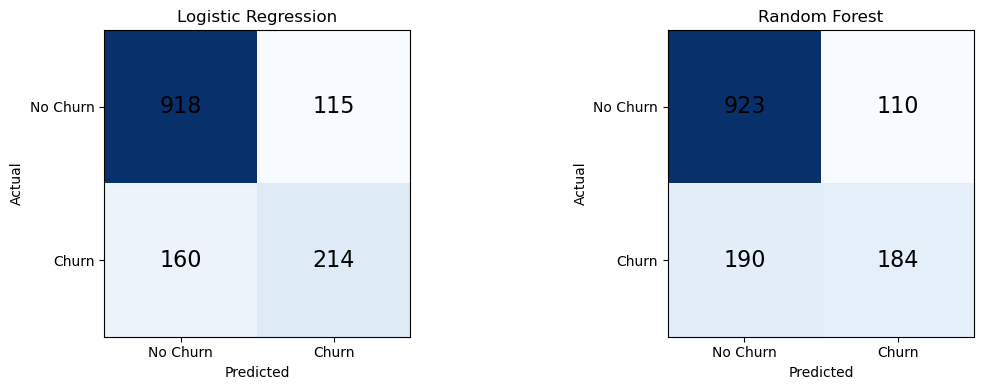

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, pred, name in zip(axes, [lr_pred, rf_pred], ['Logistic Regression', 'Random Forest']):
    cm = confusion_matrix(y_test, pred)
    ax.imshow(cm, cmap='Blues')
    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Churn', 'Churn'])
    ax.set_yticklabels(['No Churn', 'Churn'])
    
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=16)

plt.tight_layout()
plt.show()

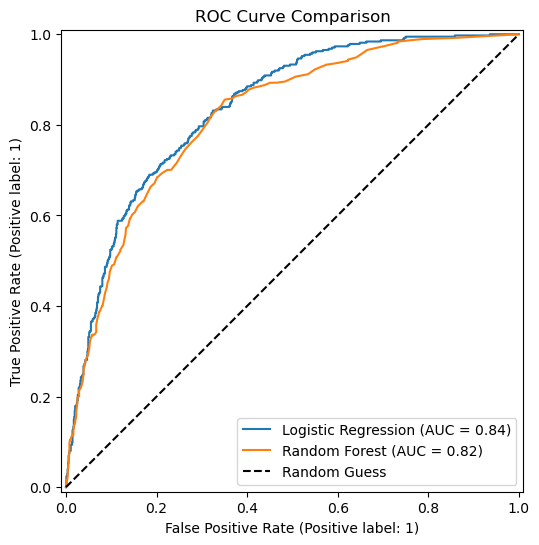

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

RocCurveDisplay.from_predictions(y_test, lr_prob, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_predictions(y_test, rf_prob, name='Random Forest', ax=ax)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## Baseline Results

| Model | Accuracy | Precision | Recall | F1 | AUC-ROC |
|-------|----------|-----------|--------|-----|---------|
| Logistic Regression | 0.8045 | 0.6505 | 0.5722 | 0.6088 | 0.8361 |
| Random Forest | 0.7868 | 0.6259 | 0.4920 | 0.5509 | 0.8184 |

### Key Observations
- Logistic Regression outperforms Random Forest on all metrics
- Data relationships are mostly linear — simple model wins
- Recall (57%) is the weak point — missing 160 churners
- False negatives are costly — priority for Day 5

### Baseline Benchmarks to Beat
- AUC: 0.8361
- Recall: 57.22%